<font color='skyblue'> Group Members: <font>


            - Riwa Masaad
            - Bemnet Teklu Assefa
            - Zeineb Rania Labidi
            - Aichen Sun
            - Chorten Tsomo Tamang




## Face Expression Recognition Dataset

This dataset contains 35,887 images of faces with different expressions. The images are divided into seven categories:

* Angry
* Disgust
* Fear
* Happy
* Sad
* Surprise
* Neutral

The dataset is split into a training set and a test set. The training set contains 28,709 images and the test set contains 7,178 images.

The images in the dataset are in JPG format and have a resolution of 48x48 pixels.

This dataset can be used to train a machine learning model to recognize facial expressions.

## Data Structure

The dataset contains the following files:

* `train`: This folder contains the training images.
* `test`: This folder contains the test images.
<br><br>

---
<br>

The following code snippet shows how to load an image from the dataset:



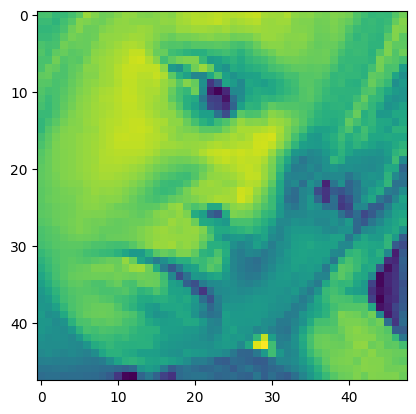

In [ ]:
# prompt: give example usage (load an image form dataset, display) load image: images/validation/fear/8797.jpg

from PIL import Image
import matplotlib.pyplot as plt

# Load an image from the dataset
image_path = 'data/validation/fear/8797.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.show()


## Modeling Strategies


### Fine-tune Models (VGG16, InceptionV3, ResNet):

Description: Fine-tuning the models for this project involved selectively unfreezing the top 2-15% of layers in pre-trained models (VGG16, InceptionV3, ResNet) and re-training them on the facial expression recognition dataset.

Implementation: Replacing the top layers.

Benefits: Enhances model performance by adapting to dataset specifics while conserving computational resources.

### Model Distillation from Improved Models:

Description: Use the predictions of the fine-tuned VGG16, InceptionV3, and ResNet models as teacher models for distillation.

Implementation: Train a simpler student model to mimic the predictions of the best model and an ensemble of improved models.

Benefits: Creates a more efficient model suitable for deployment while maintaining or improving performance metrics.

### Evaluation and Optimization:

Description: Evaluate the performance metrics (accuracy, validation loss) of each fine-tuned model and distilled student model.


### Pretrained models to be used for this task

#### 1. VGG16
VGG16 is a convolutional neural network that was developed by the Visual Geometry Group at the University of Oxford. It is a deep network, with 16  VGG16 has been shown to achieve state-of-the-art results on a variety of image classification tasks.

#### 2. ResNet
ResNet is a convolutional neural network that was developed by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. It is a very deep network, with over 100  ResNet has been shown to achieve state-of-the-art results on a variety of image classification tasks.

#### 3. Inception
Inception is a convolutional neural network that was developed by Google. It is a very deep network, with over 100  Inception has been shown to achieve state-of-the-art results on a variety of image classification tasks.


## Preprocessing steps
- Setup MLFlow
- Load dataset as train and validation already separated, loading with tensorflow library to automatically load the classes from the subfolders the images are stored in
- Shuffle dataset
- Normalize the dataset

In [ ]:
## Importing necessary libraries
import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Rescaling, Dense, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
## Setup MLflow
mlflow.set_experiment("Facial-Recognition-Project")

<Experiment: artifact_location='file:///c:/Users/bemne/OneDrive/Desktop/School/DSA_S3/ComputerVision/final-project/final-project/mlruns/198545416658839622', creation_time=1720888937253, experiment_id='198545416658839622', last_update_time=1720888937253, lifecycle_stage='active', name='Facial-Recognition-Project', tags={}>

In [ ]:
# Data loading and preprocessing
train_data_dir = 'data/train'
val_data_dir = 'data/validation'

# Tensorflow pre processing library will load each image and treat it according to its class
train_data = image_dataset_from_directory(train_data_dir, image_size=(224, 224), batch_size=32, label_mode='int')
val_data = image_dataset_from_directory(val_data_dir, image_size=(224, 224), batch_size=32, label_mode='int')

num_classes = len(train_data.class_names)

train_dataset_shuffled = train_data.shuffle(buffer_size=len(train_data))
val_dataset_shuffled = train_data.shuffle(buffer_size=len(val_data))


# Normalize the dataset
normalization_layer = Rescaling(1./255)
train_data = train_dataset_shuffled.map(lambda x, y: (normalization_layer(x), y))
val_data = val_dataset_shuffled.map(lambda x, y: (normalization_layer(x), y))

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


### Fine-tuning models to select the best performing one
We will be using the build_model function below to ensure that the transferred models are treated with the same fine-tuning steps, then choose the best performing out of the 3 for the distillation step afterwards to train our student model on, from scratch.

- Note: we are not expecting the models to have good performance as we will be training them on a fraction of the available training data due to resource constraints.

In [ ]:
def build_model(base_model, num_classes, unfreeze_percentage=0.15):
    # Unfreeze layers based on unfreeze_percentage
    if unfreeze_percentage > 0:
        num_layers = len(base_model.layers)
        unfreeze_stop_index = int(num_layers * (1 - unfreeze_percentage))
        for layer in base_model.layers[:unfreeze_stop_index]:
            layer.trainable = False
        for layer in base_model.layers[unfreeze_stop_index:]:
            layer.trainable = True

    # Add new top layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
def log_experiment(model, model_name, strategy, train_data, val_data, epochs):
    with mlflow.start_run(run_name=f"{model_name}_{strategy}"):
        model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Take smaller dataset to conserve resources
        reduced_train_data = train_data.take(int(len(train_data) * 0.05))
        reduced_val_data = val_data.take(int(len(train_data) * 0.05))

        history = model.fit(reduced_train_data, validation_data=reduced_val_data, epochs=epochs)

        # Evaluate model
        val_loss, val_acc = model.evaluate(reduced_val_data)

        # Log metrics
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_acc", val_acc)

        # Log model
        mlflow.keras.log_model(model, f"{model_name}_{strategy}")

        # Plot and log training curves
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')
        plt.savefig(f"{model_name}_{strategy}_accuracy.png")
        mlflow.log_artifact(f"{model_name}_{strategy}_accuracy.png")


#### Fine-tuning VGG16 model

Using a small unfreeze percentage to train VGG16 to only keep about 2-3 of its layers due to resource limitations and running it on 3 epochs.

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 828s 16s/step - accuracy: 0.1893 - loss: 1.9176 - val_accuracy: 0.2757 - val_loss: 1.7862
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 765s 15s/step - accuracy: 0.2568 - loss: 1.8021 - val_accuracy: 0.2931 - val_loss: 1.7311
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 759s 15s/step - accuracy: 0.2888 - loss: 1.6886 - val_accuracy: 0.3187 - val_loss: 1.6898
45/45 ━━━━━━━━━━━━━━━━━━━━ 302s 7s/step - accuracy: 0.3060 - loss: 1.6792


2024/07/14 00:36:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


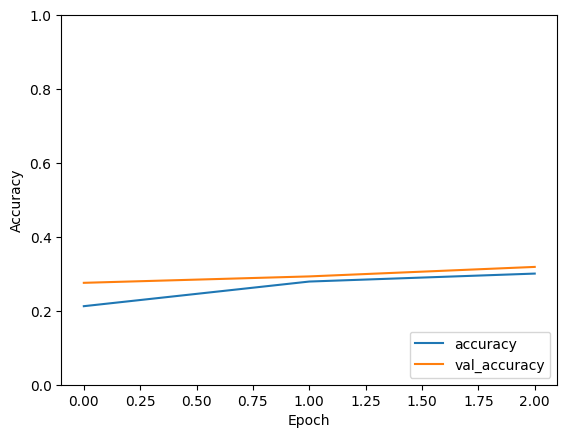

In [ ]:
# Fine-tuning VGG16
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_vgg_fine_tuning = build_model(base_vgg, num_classes, unfreeze_percentage=0.15)
log_experiment(model_vgg_fine_tuning, 'VGG16', 'fine_tuning_first_model', train_data, val_data, 3)

# Save the model for later
model_vgg_fine_tuning.save('models/model_vgg_fine_tuning.keras')

#### Fine-tuning ResNet50 model

Using a very small percentage of layers unfrozen as this model is very large with more than 100 layers, and maintaining 3 epochs for training.

In [ ]:
from tensorflow.keras.applications import ResNet50

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.1850 - loss: 2.3573 - val_accuracy: 0.1653 - val_loss: 1.9812
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.2104 - loss: 1.8876 - val_accuracy: 0.2597 - val_loss: 1.8310
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.2103 - loss: 1.8330 - val_accuracy: 0.2632 - val_loss: 1.8406
45/45 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2628 - loss: 1.8302


2024/07/14 00:54:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


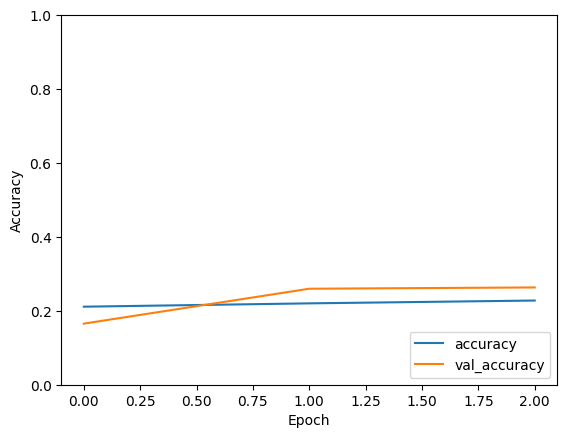

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet_fine_tuning = build_model(base_resnet, num_classes, unfreeze_percentage=0.03)
log_experiment(model_resnet_fine_tuning, 'ResNet50', 'fine_tuning', train_data, val_data, 3)

# Save the model for later
model_resnet_fine_tuning.save('models/model_resnet_fine_tuning.keras')

#### Fine-tuning InceoptionV3 model

Still using a very small percentage of layers unfrozen as this model is also very large with more than 100 layers, and maintaining 3 epochs for training.

Resulted in the best model so far

In [ ]:
from tensorflow.keras.applications import InceptionV3

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.2096 - loss: 2.6710 - val_accuracy: 0.3854 - val_loss: 1.6144
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.3634 - loss: 1.6104 - val_accuracy: 0.3931 - val_loss: 1.5359
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4066 - loss: 1.5629 - val_accuracy: 0.4389 - val_loss: 1.4899
45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4384 - loss: 1.4946


2024/07/14 01:10:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


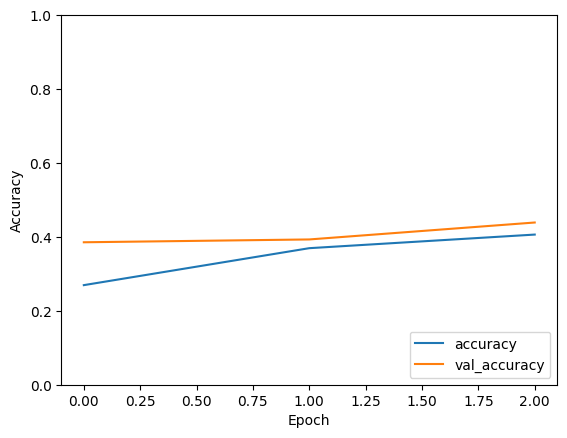

In [ ]:
# Fine-tuning InceptionV3 (GoogLeNet)
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_inception_fine_tuning = build_model(base_inception, num_classes, unfreeze_percentage=0.03)
log_experiment(model_inception_fine_tuning, 'InceptionV3', 'fine_tuning', train_data, val_data, 3)

# Save the model for later
model_inception_fine_tuning.save('models/model_inception_fine_tuning.keras')

### Model Distillation from Improved Models:

We will be defining a CNN from scratch with a distillation loss function and set it to learn from

  1. The best performing model and
  2. An ensemble model of all 3 transferred models



In [ ]:
from tensorflow.keras.models import load_model

# Load earlier transferred models
model_vgg_fine_tuning = load_model('models/model_vgg_fine_tuning.keras')
model_resnet_fine_tuning = load_model('models/model_resnet_fine_tuning.keras')
model_inception_fine_tuning = load_model('models/model_inception_fine_tuning.keras')


In [ ]:
def build_student_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())  # Flatten the tensor output before passing to Dense
    model.add(Dense(num_classes))  # No softmax activation
    return model

# Define the student model
input_shape = (224, 224, 3)  # Same input shape as the teacher models
num_classes = 7  # Number of classes for facial expression recognition
student_model = build_student_model(input_shape, num_classes)

# Compile the student model
student_model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# Display the student model summary
student_model.summary()


c:\Users\bemne\anaconda3\envs\vision\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 197136)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │     1,379,959 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,380,407 (5.27 MB)

 Trainable params: 1,380,407 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define a distillation loss function

def distillation_loss(y_true, y_pred, teacher_preds, alpha=0.1, temperature=3):
    # Ensure y_pred and teacher_preds are flattened
    y_pred = tf.reshape(y_pred, (-1, tf.shape(y_pred)[-1]))
    teacher_preds = tf.reshape(teacher_preds, (-1, tf.shape(teacher_preds)[-1]))

    # Compute hard labels loss
    hard_labels_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

    # Compute soft labels loss using Kullback-Leibler divergence
    soft_labels_loss = tf.keras.losses.kullback_leibler_divergence(
        tf.nn.softmax(tf.cast(teacher_preds, tf.float32) / temperature),
        tf.nn.softmax(y_pred / temperature)
    )

    # Combine hard and soft label losses
    combined_loss = alpha * hard_labels_loss + (1 - alpha) * soft_labels_loss

    # Reduce mean over batch size
    return tf.reduce_mean(combined_loss)


In [ ]:
from tqdm import tqdm

def log_experiment_distillation(student_model, teacher_model, model_name, strategy, train_data, val_data, epochs, alpha=0.1, temperature=3):
    with mlflow.start_run(run_name=f"{model_name}_{strategy}"):
        optimizer = Adam()
        student_model.compile(optimizer=optimizer,
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                metrics=['accuracy'])

        # Reduce dataset size to conserve resources
        reduced_train_data = train_data.take(int(len(train_data) * 0.01))
        reduced_val_data = val_data.take(int(len(val_data) * 0.01))

        # Initialize lists to store metrics for plotting
        train_accuracy_history = []
        val_accuracy_history = []

        for epoch in range(epochs):
            print(f'Starting epoch {epoch + 1}')
            train_loss = tf.keras.metrics.Mean(name='train_loss')
            train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
            val_loss = tf.keras.metrics.Mean(name='val_loss')
            val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

            # Training step
            train_data_tqdm = tqdm(reduced_train_data, desc=f'Training Epoch {epoch + 1}')
            for images, labels in train_data_tqdm:
                with tf.GradientTape() as tape:
                    teacher_preds = teacher_model(images, training=False)
                    student_preds = student_model(images, training=True)
                    loss = distillation_loss(labels, student_preds, teacher_preds, alpha, temperature)

                gradients = tape.gradient(loss, student_model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

                train_loss(loss)
                train_accuracy(labels, student_preds)

                train_data_tqdm.set_postfix({'loss': train_loss.result().numpy(), 'accuracy': train_accuracy.result().numpy()})

            # Validation step
            val_data_tqdm = tqdm(reduced_val_data, desc=f'Validation Epoch {epoch + 1}')
            for val_images, val_labels in val_data_tqdm:
                student_preds = student_model(val_images, training=False)
                v_loss = tf.keras.losses.sparse_categorical_crossentropy(val_labels, student_preds)

                val_loss(v_loss)
                val_accuracy(val_labels, student_preds)

                val_data_tqdm.set_postfix({'val_loss': val_loss.result().numpy(), 'val_accuracy': val_accuracy.result().numpy()})

            # Log metrics
            mlflow.log_metric('val_loss', val_loss.result().numpy(), step=epoch)
            mlflow.log_metric('val_accuracy', val_accuracy.result().numpy(), step=epoch)

            # Store metrics for plotting
            train_accuracy_history.append(train_accuracy.result().numpy())
            val_accuracy_history.append(val_accuracy.result().numpy())

            print(f'Epoch {epoch + 1}, Train Loss: {train_loss.result()}, Train Accuracy: {train_accuracy.result()}, Val Loss: {val_loss.result()}, Val Accuracy: {val_accuracy.result()}')

        # Final evaluation
        val_loss_final, val_acc_final = student_model.evaluate(reduced_val_data)
        mlflow.log_metric("final_val_loss", val_loss_final)
        mlflow.log_metric("final_val_acc", val_acc_final)

        # Log the student model
        mlflow.keras.log_model(student_model, f"{model_name}_{strategy}")

        # Plot and log training curves
        plt.plot(range(epochs), train_accuracy_history, label='train_accuracy')
        plt.plot(range(epochs), val_accuracy_history, label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')
        plt.savefig(f"{model_name}_{strategy}_accuracy.png")
        mlflow.log_artifact(f"{model_name}_{strategy}_accuracy.png")


#### Distillation method 1:
Use the teacher model to be the best performing model from the transferred models

**Best performing model** (using accuracy metric): InceptionV3

In [ ]:
# Resize and normalize the dataset as we only did normalization before
resize_layer = tf.keras.layers.Resizing(224, 224)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_data_resized = train_dataset_shuffled.map(lambda x, y: (normalization_layer(resize_layer(x)), y))
val_data_resized = val_dataset_shuffled.map(lambda x, y: (normalization_layer(resize_layer(x)), y))


Starting epoch 1


Validation Epoch 1: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s, val_loss=6.45, val_accuracy=0.156]


Epoch 1, Train Loss: 9.417902946472168, Train Accuracy: 0.15625, Val Loss: 6.450462818145752, Val Accuracy: 0.15625
Starting epoch 2


Validation Epoch 2: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s, val_loss=2.54, val_accuracy=0.0174]


Epoch 2, Train Loss: 1.7340961694717407, Train Accuracy: 0.1423611044883728, Val Loss: 2.537980079650879, Val Accuracy: 0.0173611119389534
Starting epoch 3


Validation Epoch 3: 100%|██████████| 18/18 [00:12<00:00,  1.40it/s, val_loss=6.09, val_accuracy=0.205]


Epoch 3, Train Loss: 0.19498847424983978, Train Accuracy: 0.1805555522441864, Val Loss: 6.093152046203613, Val Accuracy: 0.2048611044883728
Starting epoch 4


Validation Epoch 4: 100%|██████████| 18/18 [00:10<00:00,  1.67it/s, val_loss=5.37, val_accuracy=0.286]


Epoch 4, Train Loss: 0.19307729601860046, Train Accuracy: 0.203125, Val Loss: 5.374803066253662, Val Accuracy: 0.2864583432674408
Starting epoch 5


Validation Epoch 5: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s, val_loss=5.13, val_accuracy=0.245]


Epoch 5, Train Loss: 0.192878857254982, Train Accuracy: 0.2586805522441864, Val Loss: 5.125392436981201, Val Accuracy: 0.2447916716337204
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.2407 - loss: 1.9105


2024/07/14 12:46:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


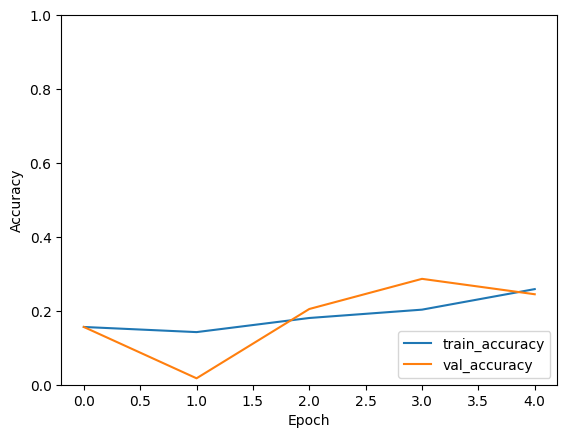

In [ ]:
teacher_model = model_inception_fine_tuning
input_shape = (224, 224, 3)
num_classes = 7
student_model_with_best = build_student_model(input_shape, num_classes)

# Train the student model with distillation and MLflow logging
log_experiment_distillation(student_model_with_best, teacher_model, 'StudentModel', 'distillation_with_best', train_data_resized, val_data_resized, epochs=5)

In [ ]:
#  Save thr trained student model
student_model_with_best.save('models/student_model_with_best.keras')

#### Distillation method 2:
Use an ensemble model of the 3 transferred models to distill the student model

In [ ]:
from tensorflow.keras.layers import Average

def build_ensemble_model(models, input_shape):
    # Inputs to the ensemble model
    inputs = tf.keras.Input(shape=input_shape)

    # Get outputs from each model
    model_outputs = [model(inputs, training=False)[0] for model in models]  # Extract the tensor from the list
    averaged_output = Average()(model_outputs)  # Average the outputs

    # Create the ensemble model
    ensemble_model = Model(inputs, averaged_output, name='ensemble_model')

    return ensemble_model

In [ ]:
input_shape = (224, 224, 3)

vgg16_model = model_vgg_fine_tuning
resnet_model = model_resnet_fine_tuning
inception_model = model_inception_fine_tuning

# Create the ensemble teacher model
teacher_models = [vgg16_model, resnet_model, inception_model]
ensemble_teacher_model = build_ensemble_model(teacher_models, input_shape)

In [ ]:
ensemble_teacher_model.save('models/ensemble_teacher_model.keras')

Starting epoch 1


Validation Epoch 1: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it, val_loss=3.3, val_accuracy=0.188] 


Epoch 1, Train Loss: 2.6580870151519775, Train Accuracy: 0.1840277761220932, Val Loss: 3.3038392066955566, Val Accuracy: 0.1875
Starting epoch 2


Validation Epoch 2: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it, val_loss=4.87, val_accuracy=0.146]


Epoch 2, Train Loss: 0.7178002595901489, Train Accuracy: 0.1701388955116272, Val Loss: 4.866293430328369, Val Accuracy: 0.1458333283662796
Starting epoch 3


Validation Epoch 3: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s, val_loss=2.86, val_accuracy=0.181]


Epoch 3, Train Loss: 0.31736576557159424, Train Accuracy: 0.1215277761220932, Val Loss: 2.864285469055176, Val Accuracy: 0.1805555522441864
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1632 - loss: 2.2676


2024/07/14 13:56:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


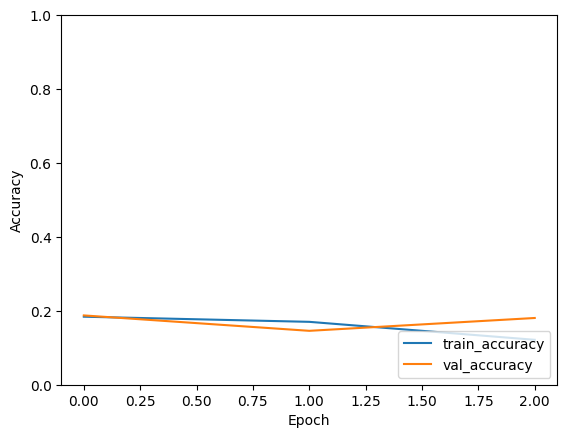

In [ ]:
teacher_model = ensemble_teacher_model
input_shape = (224, 224, 3)
num_classes = 7
student_model_with_ensemble = build_student_model(input_shape, num_classes)

# Train the student model with distillation and MLflow logging
log_experiment_distillation(student_model_with_ensemble, teacher_model, 'StudentModel', 'distillation_with_ensemble', train_data, val_data, epochs=3)

In [ ]:
student_model_with_ensemble.save('models/student_model_with_ensemble.keras')

## Evaluation

In [18]:
## Log metrics from MLflow
import mlflow
import pandas as pd

# Set the MLflow tracking URI to localhost:5000
mlflow.set_tracking_uri('http://localhost:5000')

In [19]:

# Search for runs and fetch metrics
experiment_name = 'Facial-Recognition-Project'  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Initialize DataFrame to store metrics
metrics_list = []

# Function to fetch metric from a run
def get_metric(metrics, metric_name, default=None):
    return metrics.get(metric_name, default)

# Iterate over runs and fetch metrics
for idx, run in runs.iterrows():
    run_id = run['run_id']
    run_name = run['tags.mlflow.runName']  # Fetch the run name
    metrics = run.to_dict()

    # Fetch all four metrics (logging was not consistent in student and transferred models)
    final_val_loss = get_metric(metrics, 'metrics.final_val_loss')
    final_val_accuracy = get_metric(metrics, 'metrics.final_val_acc')
    val_loss = get_metric(metrics, 'metrics.val_loss')
    val_accuracy = get_metric(metrics, 'metrics.val_acc')

    # Append appropriate metrics based on availability
    if final_val_loss is not None and final_val_accuracy is not None:
        metrics_list.append({
            'run_id': run_id,
            'run_name': run_name,
            'final_val_loss': final_val_loss,
            'final_val_accuracy': final_val_accuracy,
            'source': 'student'
        })
    if val_loss is not None and val_accuracy is not None:
        metrics_list.append({
            'run_id': run_id,
            'run_name': run_name,
            'final_val_loss': val_loss,
            'final_val_accuracy': val_accuracy,
            'source': 'transferred'
        })

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(metrics_list).dropna()
metrics_df

,run_id,run_name,final_val_loss,final_val_accuracy,source
0,ae6bebf64b924e03b62d6a3cc5b70ee6,StudentModel_distillation_with_ensemble,2.282163,0.163194,student
2,7f6ef62b692643df968b33f669a1cbd5,StudentModel_distillation_with_best,1.911695,0.239583,student
5,cfd05b57d89041e995b637cb4062f106,InceptionV3_fine_tuning,1.497397,0.430556,transferred
7,bbe84ee8b86d44ce902697d2eabb3b40,ResNet50_fine_tuning,1.835376,0.251389,transferred
9,6d7d8524693347379a9431ff080fb6ab,VGG16_fine_tuning_first_model,1.683449,0.315278,transferred


In [20]:
# Mapping for run names for easier display
run_name_mapping = {
    'StudentModel_distillation_with_ensemble': 'student_ensemble',
    'StudentModel_distillation_with_best': 'student_best',
    'InceptionV3_fine_tuning': 'inceptionV3',
    'ResNet50_fine_tuning': 'resnet50',
    'VGG16_fine_tuning_first_model': 'vgg16'
}

# Rename run_name column based on the mapping
metrics_df['run_name'] = metrics_df['run_name'].map(run_name_mapping)
metrics_df


,run_id,run_name,final_val_loss,final_val_accuracy,source
0,ae6bebf64b924e03b62d6a3cc5b70ee6,student_ensemble,2.282163,0.163194,student
2,7f6ef62b692643df968b33f669a1cbd5,student_best,1.911695,0.239583,student
5,cfd05b57d89041e995b637cb4062f106,inceptionV3,1.497397,0.430556,transferred
7,bbe84ee8b86d44ce902697d2eabb3b40,resnet50,1.835376,0.251389,transferred
9,6d7d8524693347379a9431ff080fb6ab,vgg16,1.683449,0.315278,transferred


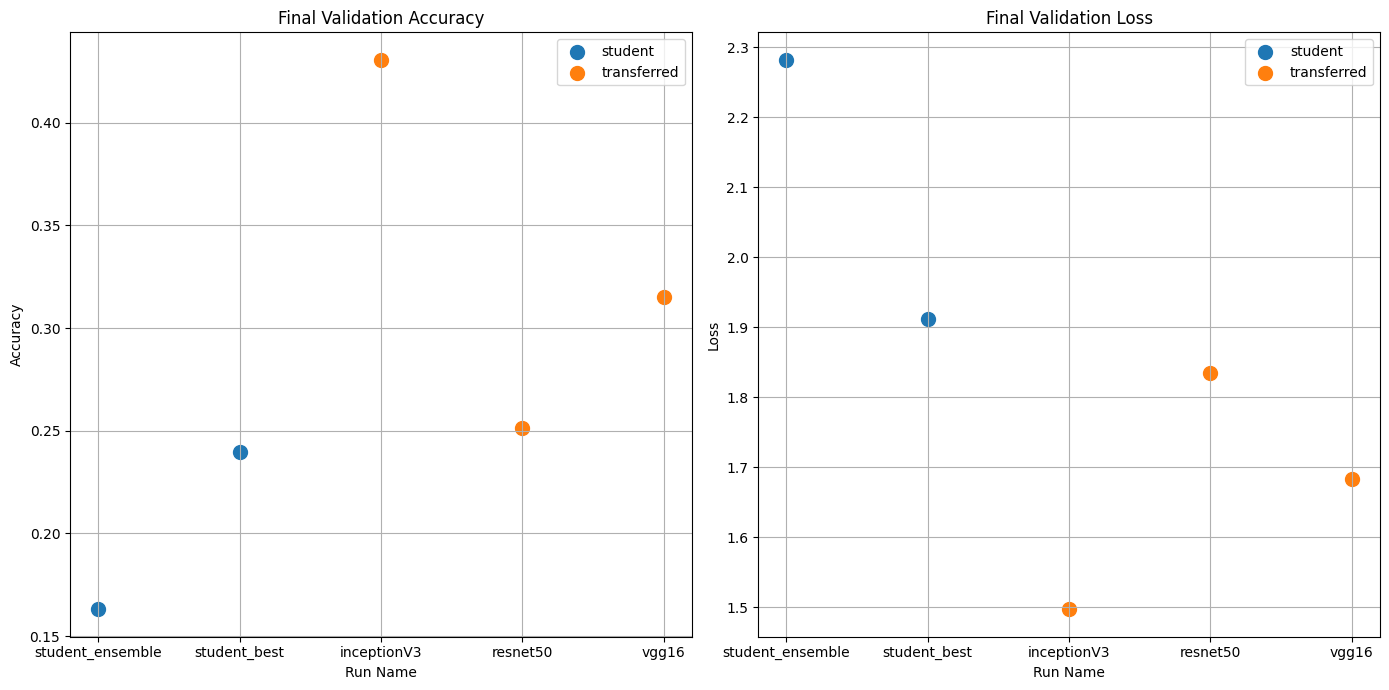

In [25]:
import matplotlib.pyplot as plt

# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot Validation Loss
for source in metrics_df['source'].unique():
    subset = metrics_df[metrics_df['source'] == source]
    ax[1].scatter(subset['run_name'], subset['final_val_loss'], label=source, s=100)
ax[1].set_title('Final Validation Loss')
ax[1].set_xlabel('Run Name')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)
ax[1].tick_params(axis='x')

# Plot Validation Accuracy
for source in metrics_df['source'].unique():
    subset = metrics_df[metrics_df['source'] == source]
    ax[0].scatter(subset['run_name'], subset['final_val_accuracy'], label=source, s=100)
ax[0].set_title('Final Validation Accuracy')
ax[0].set_xlabel('Run Name')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)
ax[0].tick_params(axis='x')

plt.tight_layout()
plt.show()

<hr>

### Analysis
#### Transferred Models:

InceptionV3: The best performing transferred model with a validation loss of 1.497397 and accuracy of 0.430556.<br>
ResNet50: Achieved a validation loss of 1.835376 and accuracy of 0.251389.<br>
VGG16: Achieved a validation loss of 1.683449 and accuracy of 0.315278.<br>

#### Student Models (Distillation):

Distillation with Ensemble: Resulted in a validation loss of 2.282163 and accuracy of 0.163194. <br>
Distillation with Best Model (InceptionV3): Resulted in a validation loss of 1.911695 and accuracy of 0.239583. <br>

<hr>

### Project Choices and Justifications

1. Model Distillation:

Model distillation was chosen to explore its effectiveness in training smaller models (student models) using the knowledge distilled from larger, pretrained models (teacher models). This was particularly relevant given the constraints of using an extremely small dataset.

**Distillation with the Best Transferred Model**:<br>
*Reason*: InceptionV3 was chosen as the teacher model for distillation because it demonstrated the best performance among the transferred models. The goal was to see if the superior knowledge of InceptionV3 could help the student model achieve better performance despite the small dataset size.

**Distillation with an Ensemble**:<br>
*Reason*: An ensemble of transferred models was used to distill knowledge into a student model to investigate if combining the strengths of multiple models could lead to a better generalized student model. The hypothesis was that the ensemble could provide a more robust and comprehensive set of features for the student model to learn from.

2. Training on Small Datasets:<br>
*Reason*: The project aimed to explore different training methodologies while conserving computational resources. Given the extremely small dataset, it was understood that achieving high performance was unlikely. The primary objective was to learn and evaluate various model training techniques.

3. Model Fine-Tuning:

**Transferred Models**: Pretrained models (InceptionV3, ResNet50, VGG16) were fine-tuned on the small dataset to leverage their pretrained weights and features. Fine-tuning was expected to give these models a head start by adapting the already learned representations to the new dataset.

4. Performance Expectations:<br>
*Reason*: Due to the small dataset size, the models were expected to perform poorly. This was accepted as a part of the project’s learning goals, focusing more on the process and methodologies rather than the absolute performance metrics.

<hr>

## Conclusion
The project provided valuable insights into different model training approaches under constrained resources. While the performance metrics were understandably low due to the small dataset, the experiments helped in understanding the trade-offs and potential benefits of model distillation, fine-tuning of transferred models, and the use of ensembles. This knowledge can be applied to future projects with more substantial datasets to achieve better performance.

<hr>

## Bibliography


1. Keras Example on Knowledge Distillation:

*Title*: “Knowledge Distillation in Keras: A Practical Guide with Examples”<br>
*Link*: https://keras.io/examples/vision/knowledge_distillation/

2. Analytics Vidhya Article on Knowledge Distillation:

*Title*: “Knowledge Distillation: Theory and End-to-End Case Study”<br>
*Link*: https://www.analyticsvidhya.com/blog/2022/01/knowledge-distillation-theory-and-end-to-end-case-study/

3. Medium article on Ensemble models:

*Title*: “Ensemble models: Boosting model performance through collaborative learning”<br>
*Link*: https://medium.com/predict/ensemble-models-boosting-model-performance-through-collaborative-learning-13bbcd6aaeb7

4. Kaggle notebook on knowledge distillation:

*Title*: “Knowledge Distillation”<br>
*Link*: https://www.kaggle.com/code/ritvik1909/knowledge-distillation
